In [2]:
#%%
from array import array
from cmath import nan
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torchvision
import torchvision.transforms as transforms
from itertools import chain
from sklearn import metrics as met
import pickle
import icecream as ic
import torchsummary
import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
import util
from torchmetrics import Accuracy
from torch.utils.data.datapipes.datapipe import _IterDataPipeSerializationWrapper, _MapDataPipeSerializationWrapper
from torch.utils.data import default_convert
from tqdm import tqdm
import time



/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
seqs_df, res_all = util.load_data.get_main_dataset()
N_samples = seqs_df.shape[0]
DRUGS = util.DRUGS
LOCI = seqs_df.columns
assert set(DRUGS) == set(res_all.columns)
N_drugs = len(DRUGS)

# load the CRyPTIC samples as test data
seqs_cryptic, res_cryptic = util.load_data.get_cryptic_dataset()
# make sure the loci are in the same order as in the training data
seqs_cryptic = seqs_cryptic[seqs_df.columns]



In [17]:
spread_sheet = pd.read_csv('tb_data_2022_08_19.csv', header=0)
DRUGS = util.DRUGS
LOCI = seqs_df.columns
assert set(DRUGS) == set(res_all.columns)
N_drugs = len(DRUGS)

def one_hot_torch(seq: str, dtype=torch.int8):
    seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
    acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
    arr = torch.zeros(4, (len(seq_bytes)), dtype=dtype)
    arr[0, seq_bytes == acgt_bytes[0]] = 1
    arr[1, seq_bytes == acgt_bytes[1]] = 1
    arr[2, seq_bytes == acgt_bytes[2]] = 1
    arr[3, seq_bytes == acgt_bytes[3]] = 1
    return arr

def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


class Model(nn.Module):
    def __init__(
        self,
        in_channels=4,
        num_classes=1,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        # now define the actual model
        self.feature_extraction_layer = self._conv_layer(
            in_channels, num_filters, filter_length
        )
        self.conv_layers = nn.ModuleList(
            self._conv_layer(num_filters, num_filters, 3)
            for _ in range(num_conv_layers)
        )
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [num_filters]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.Sigmoid()) #difference between sequential and nn.moduleList?
        )

    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )

    def forward(self, x):
        # first pass over input
        # print(x.size())
        x = self.feature_extraction_layer(x)
        # conv layers
        for layer in self.conv_layers:
            x = layer(x)
        # global max pool 1D
        x = torch.max(x, dim=-1).values
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        x = self.prediction_layer(x)
        return x
    


In [18]:
#res_cryptic1 has the same dimension as the training data, so that it's output is also 13 event though the y value only has 8 DR
missing_res = set(res_all.columns).difference(res_cryptic.columns)
miss_df = pd.DataFrame(columns=missing_res)
res_cryptic1 = pd.concat([res_cryptic, miss_df])
res_cryptic1 = res_cryptic1[res_all.columns]

#%%
#creating eval Dataloader
LOCI = seqs_cryptic.columns
DRUGS = res_all.columns

class OneHotSeqsDataset_val(torch.utils.data.Dataset):
    def __init__(
        self,
        seq_cryptic,
        res_cryptic,
        target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
    ):
        self.seq_cryptic = seq_cryptic[target_loci]
        self.res_cryptic = res_cryptic[target_drugs]
        if not self.seq_cryptic.index.equals(self.res_cryptic.index):
            raise ValueError(
                "Indices of sequence and resistance dataframes don't match up"
            )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_cryptic.iloc[index].str.cat()
            res = self.res_cryptic.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_cryptic.loc[index].str.cat()
            res = self.res_cryptic.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )
        return one_hot_torch(seqs_comb, dtype=self.one_hot_dtype), torch.tensor(res)

    def __len__(self):
        return self.res_cryptic.shape[0]

dataset = OneHotSeqsDataset_val(seqs_cryptic, res_cryptic1, one_hot_dtype=torch.float)

loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, collate_fn=collate_padded_batch
)



In [19]:
# AUC calculation
from torchmetrics import AUROC

def auc_func(preds, y_stack):
    res_index = [res_all.columns.tolist().index(x) for x in res_cryptic.columns.tolist()]
    dr_cryptic = ['ISONIAZID','RIFAMPICIN','ETHAMBUTOL','AMIKACIN','KANAMYCIN','MOXIFLOXACIN','LEVOFLOXACIN','ETHIONAMIDE']
    y_stack =  torch.cat(y_, dim=0)
    y_select =  y_stack[:, res_index]

    preds_stack = torch.cat(preds, dim=0)
    preds_select = preds_stack[:, res_index]
    auc_dict = {}
    for x in range(y_select.size()[1]):
        no_nan = ~y_select[:,x].isnan()
        pred_masked = preds_select[:,x][no_nan].to(device)
        y_masked = y_select[:,x][no_nan].to(device)
        # ic(pred_masked, y_masked)
        # ic(len(pred_masked), len(y_masked))
        auroc = AUROC(pos_label=1)
        auc = auroc(pred_masked, y_masked.int())
        auc = auc.cpu().numpy().tolist()
        auc_dict[dr_cryptic[x]] = auc 
    return auc_dict

def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.annotate(y_list[i-1],(i-1,y_list[i-1]),ha="center")
#plotting auc
def auc_plot(name, auc_dict):
    # plt.bar(*zip(*auc_dict.items()))
    # plt.ylim(0,1)
    # plt.xticks(rotation = 45)
    # plt.title(f'AUC_{name}')
    # for i, v in enumerate(auc_dict.values):
    #     plt.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    fig, ax = plt.subplots()
    ax.bar(auc_dict.keys(), auc_dict.values())
    ax.tick_params(axis='x', labelrotation = 45)
    add_value_label(list(auc_dict.keys()),[round(x,2) for x in list(auc_dict.values())])
    ax.set_xlabel("Drug resistances")
    ax.set_ylabel("AUC")
    ax.set_ylim(0,1)
    ax.set_title(f'AUC_{name}-avg-{np.mean(list(auc_dict.values()))}')
    fig.tight_layout()
    fig.show()
    


In [20]:
def output_accuracy(preds, spread_sheet, wgs_id):
       preds1 = torch.cat(preds)
       preds1 = torch.round(preds1)
       final_pred = torch.sum(preds1, dim=0)
       dr = ['AMIKACIN', 'CAPREOMYCIN', 'CIPROFLOXACIN', 'ETHAMBUTOL', 'ETHIONAMIDE',
              'ISONIAZID', 'KANAMYCIN', 'LEVOFLOXACIN', 'MOXIFLOXACIN', 'OFLOXACIN',
              'PYRAZINAMIDE', 'RIFAMPICIN', 'STREPTOMYCIN']
       # list_ = ["rifampicin","isoniazid","ethambutol","pyrazinamide","streptomycin","ofloxacin","moxifloxacin","levofloxacin","amikacin","kanamycin","capreomycin","ciprofloxacin","prothionamide","ethionamide","clarithromycin","clofazimine","bedaquiline","cycloserine","linezolid","para-aminosalicylic_acid","rifabutin","delamanid"]

       y_true_df = pd.DataFrame(spread_sheet[spread_sheet['wgs_id']== wgs_id].reset_index().loc[0][21:43]).T
       y_true_df = y_true_df.loc[:,["amikacin","capreomycin","ciprofloxacin","ethambutol","ethionamide","isoniazid","kanamycin","levofloxacin","moxifloxacin","ofloxacin","pyrazinamide","rifampicin","streptomycin"]]
       
       df_ = pd.DataFrame(columns=dr)
       results = final_pred.numpy().tolist()
       df_.loc[0] = results
       df_.loc[1] = y_true_df.loc[0].tolist()
       print(df_)
       # print(df_)

       df_nona = df_.loc[:, ~(df_.isna()).any()]
       true = list(map(int, df_nona.loc[1].tolist()))
       out = list(map(int, df_nona.loc[0].tolist()))
       
       from sklearn.metrics import accuracy_score
       df_['wgs_id'] = wgs_id
       # print('accuracy_score:',accuracy_score(true, out))
       return accuracy_score(true, out), df_

<h3>Full model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5           [-1, 128, 49976]               0
            Conv1d-6           [-1, 128, 49974]          49,280
       BatchNorm1d-7           [-1, 128, 49974]             256
              ReLU-8           [-1, 128, 49974]               0
           Dropout-9           [-1, 128, 49974]               0
           Conv1d-10           [-1, 128, 49972]          49,280
      BatchNorm1d-11           [-1, 128, 49972]             256
             ReLU-12           [-1, 128, 49972]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

100%|██████████| 1051/1051 [00:50<00:00, 20.97it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_57682/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


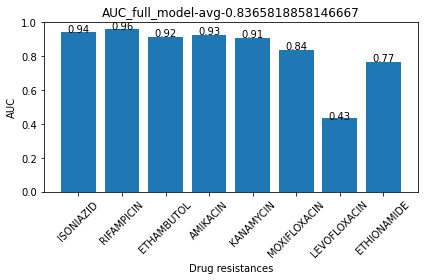

In [21]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=2,
    num_dense_neurons=64,
    num_dense_layers=3,
    return_logits=True,
).to(device)
m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_model.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))

preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)
# print('-----------------------')

auc_dict = auc_func(preds, y_)
auc_plot('full_model', auc_dict)


<h3>Reduced Model

In [ ]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=2,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_model_0c2d.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)
# print('-----------------------')

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_1_dense_model', auc_dict)

<h3>Reduce reduce model - dropping all dense layers

In [ ]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_model', auc_dict)

<h3>Reduce reduce reduce model 64 filter instead of 128

In [ ]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=64,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d64f.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_64f_model', auc_dict)

<h3>decreasing number of filters and neurons

In [ ]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=32,
    num_conv_layers=0,
    num_dense_neurons=32,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d32f32n.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_32f32n_model', auc_dict)

<h3>again decreasing number of filters and neurons

In [ ]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=8,
    num_conv_layers=0,
    num_dense_neurons=8,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d8f8n.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_8f8n_model', auc_dict)

In [ ]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=16,
    num_conv_layers=0,
    num_dense_neurons=16,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d16f16n.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_16f16n_model', auc_dict)

16f16n - with batch size 16
<br>scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [ ]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=16,
    num_conv_layers=0,
    num_dense_neurons=16,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_split_model_16f16n-50e'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_16f16n_model', auc_dict)

32f32n

In [ ]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=32,
    num_conv_layers=0,
    num_dense_neurons=32,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_split_model_32f32n-20e'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))

preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_16f16n_model', auc_dict)

128f64n

In [ ]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_split_model_128f64n-20e'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_16f16n_model', auc_dict)

In [ ]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_split_model_128f64n-20e1'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_16f16n_model', auc_dict)

128f64n with all data

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1051/1051 [00:36<00:00, 28.65it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_68172/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


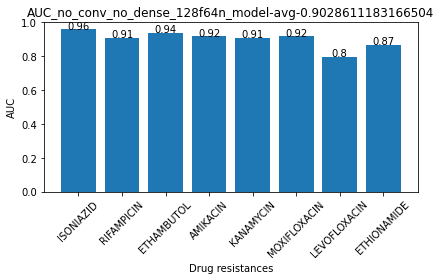

In [190]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d128f64n_d.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_128f64n_model', auc_dict)

Model with gap 50X

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1051/1051 [00:37<00:00, 28.17it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


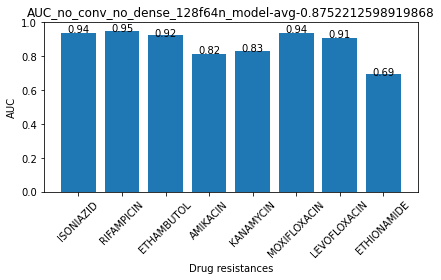

In [6]:
#%%
#device = 'cpu'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d128f64n_d-separator50.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)

auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_128f64n_model', auc_dict)

model with gap 30X

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1051/1051 [00:36<00:00, 28.64it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


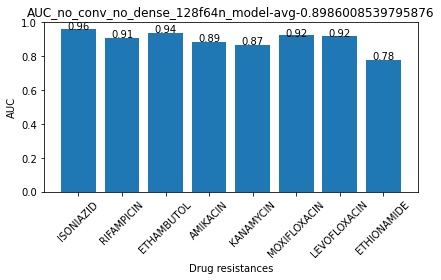

In [21]:
#%%
#device = 'cpu'

loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, collate_fn=collate_padded_batch
)

device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d128f64n_d-separator30.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []


# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)



auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_128f64n_model', auc_dict)

<h2>Testing inference speed

Vertical input

In [28]:
start_time = time.time()
single_test_data = pd.read_csv('./test/merged-file', sep=" ", header=None)
single_test_data.columns = ['seq']
single_test_data['x'] = 'X'*25
single_test_data['x_added'] = single_test_data['x'] + single_test_data['seq'] + single_test_data['x']
single_test_data = single_test_data.drop(['x','seq'], axis = 1)
# max_seq = single_test_data['x_added'] .str.split("").str.len().max()
single_test_data['x_added'] = single_test_data['x_added'].str.split('',expand=True).fillna('X').apply(lambda x: x.str.cat(sep=''), axis=1)
single_test_data['_'] = 0 
print("--- %s seconds ---" % (time.time() - start_time))


--- 92.80801129341125 seconds ---


In [30]:
class OneHotSeqsDataset_test(torch.utils.data.Dataset):
    def __init__(
        self,
        single_test_data,
        target_loci='x_added',
        target_drugs='_',
        one_hot_dtype=torch.int8,
    ):
        self.seq = single_test_data[target_loci]
        self.res = single_test_data[target_drugs]
        if not self.seq.index.equals(self.res.index):
            raise ValueError(
                "Indices of sequence and resistance dataframes don't match up"
            )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq.iloc[index]
            res = self.res.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq.loc[index]
            res = self.res.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )
        return one_hot_torch(seqs_comb, dtype=self.one_hot_dtype), torch.tensor(res)

    def __len__(self):
        return self.res.shape[0]

dataset = OneHotSeqsDataset_test(single_test_data, one_hot_dtype=torch.float)




In [31]:
#%%
#device = 'cpu'

start_time = time.time()

test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, collate_fn=collate_padded_batch
)

device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d128f64n_d-separator30.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, _ in tqdm(test_loader):
    x_batch = x_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    # y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)
    # print(preds)
# auc_dict = auc_func(preds, y_)
# auc_plot('no_conv_no_dense_128f64n_model', auc_dict)


print("--- %s seconds ---" % (time.time() - start_time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 81921/81921 [02:45<00:00, 494.04it/s]

--- 166.48063230514526 seconds ---


In [32]:
#target-outout comparision
preds1 = torch.cat(preds)
preds1 = torch.round(preds1)
final_pred = torch.sum(preds1, dim=0) 
dr = ['AMIKACIN', 'CAPREOMYCIN', 'CIPROFLOXACIN', 'ETHAMBUTOL', 'ETHIONAMIDE',
       'ISONIAZID', 'KANAMYCIN', 'LEVOFLOXACIN', 'MOXIFLOXACIN', 'OFLOXACIN',
       'PYRAZINAMIDE', 'RIFAMPICIN', 'STREPTOMYCIN']

list_ = ["rifampicin","isoniazid","ethambutol","pyrazinamide","streptomycin","ofloxacin","moxifloxacin","levofloxacin","amikacin","kanamycin","capreomycin","ciprofloxacin","prothionamide","ethionamide","clarithromycin","clofazimine","bedaquiline","cycloserine","linezolid","para-aminosalicylic_acid","rifabutin","delamanid"]
y_true_df = pd.DataFrame(columns=list_)
y_true = ['1','1','1','1','1','0','0','NA','0','0','0','NA','NA','1','NA','NA','NA','0','0','0','NA','NA']
y_true_df .loc[0] = y_true
y_true_df = y_true_df.loc[:,["amikacin","capreomycin","ciprofloxacin","ethambutol","ethionamide","isoniazid","kanamycin","levofloxacin","moxifloxacin","ofloxacin","pyrazinamide","rifampicin","streptomycin"]]

df_ = pd.DataFrame(columns=dr)
results = final_pred.numpy().tolist()
df_.loc[0] = results
df_.loc[1] = y_true_df.loc[0].tolist()

df_

tensor([1.0000e+01, 8.0000e+00, 1.6200e+02, 2.3100e+02, 9.5000e+02, 1.5744e+04,
        0.0000e+00, 4.7420e+04, 4.9000e+01, 1.1140e+03, 2.2500e+02, 8.5100e+02,
        6.1400e+02])

horizontal input

In [24]:
start_time = time.time()

single_test_data = pd.read_csv('./test/merged-file', sep=" ", header=None)
single_test_data.columns = ['seq']
single_test_data['x'] = 'X'*25
single_test_data['x_added'] = single_test_data['x'] + single_test_data['seq'] + single_test_data['x']
single_test_data = single_test_data.drop(['x','seq'], axis = 1)
# max_seq = single_test_data['x_added'] .str.split("").str.len().max()
single_test_data['x_added'] = single_test_data['x_added'].str.split('',expand=True).fillna('X').apply(lambda x: x.str.cat(sep=''), axis=1)
seq_ = "".join(single_test_data['x_added'].tolist())
single_test_data = pd.DataFrame({'x_added':[seq_],'_':[0]})

print("--- %s seconds ---" % (time.time() - start_time))

--- 45.30420184135437 seconds ---


In [26]:
class OneHotSeqsDataset_test(torch.utils.data.Dataset):
    def __init__(
        self,
        single_test_data,
        target_loci='x_added',
        target_drugs='_',
        one_hot_dtype=torch.int8,
    ):
        self.seq = single_test_data[target_loci]
        self.res = single_test_data[target_drugs]
        if not self.seq.index.equals(self.res.index):
            raise ValueError(
                "Indices of sequence and resistance dataframes don't match up"
            )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq.iloc[index]
            res = self.res.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq.loc[index]
            res = self.res.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )
        return one_hot_torch(seqs_comb, dtype=self.one_hot_dtype), torch.tensor(res)

    def __len__(self):
        return self.res.shape[0]

dataset = OneHotSeqsDataset_test(single_test_data, one_hot_dtype=torch.float)




In [27]:
#%%
#device = 'cpu'

start_time = time.time()

test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, collate_fn=collate_padded_batch
)

device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d128f64n_d-separator30.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, _ in tqdm(test_loader):
    x_batch = x_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    # y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)
    # print(preds)
# auc_dict = auc_func(preds, y_)
# auc_plot('no_conv_no_dense_128f64n_model', auc_dict)


print("--- %s seconds ---" % (time.time() - start_time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

  0%|          | 0/1 [00:04<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 46.22 GiB (GPU 0; 31.75 GiB total capacity; 1.50 GiB already allocated; 29.15 GiB free; 1.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

middle ground

In [ ]:

start_time = time.time()
single_test_data = pd.read_csv('./test/merged-file', sep=" ", header=None)
single_test_data.columns = ['seq']
single_test_data['x'] = 'X'*25
single_test_data['x_added'] = single_test_data['x'] + single_test_data['seq'] + single_test_data['x']
single_test_data = single_test_data.drop(['x','seq'], axis = 1)
single_test_data['x_added'] = single_test_data['x_added'].str.split('',expand=True).fillna('X').apply(lambda x: x.str.cat(sep=''), axis=1)

array_ = np.array_split(single_test_data, 422)
single_test_data_mod = array_[0]

for x in range(1,len(array_)):  
    single_test_data_mod = single_test_data_mod + array_[x].reset_index(drop=True)

single_test_data_mod['_'] = 0
single_test_data = single_test_data_mod

print("--- %s seconds ---" % (time.time() - start_time))

In [110]:

start_time = time.time()
single_test_data = pd.read_csv('./test/merged-file', sep=" ", header=None)
single_test_data.columns = ['seq']
single_test_data['x_added'] = single_test_data['seq'].str.split('',expand=True).fillna('X').apply(lambda x: x.str.cat(sep=''), axis=1)
single_test_data = single_test_data.drop(['seq'], axis = 1)

array_ = np.array_split(single_test_data, 422)
single_test_data_mod = array_[0]

for x in range(1,len(array_)):  
    single_test_data_mod = single_test_data_mod + array_[x].reset_index(drop=True)

single_test_data_mod['_'] = 0
single_test_data = single_test_data_mod

print("--- %s seconds ---" % (time.time() - start_time))

--- 89.86928200721741 seconds ---


raw reads input with model trained with separators

In [32]:
class OneHotSeqsDataset_test(torch.utils.data.Dataset):
    def __init__(
        self,
        single_test_data,
        target_loci='x_added',
        target_drugs='_',
        one_hot_dtype=torch.int8,
    ):
        self.seq = single_test_data[target_loci]
        self.res = single_test_data[target_drugs]
        if not self.seq.index.equals(self.res.index):
            raise ValueError(
                "Indices of sequence and resistance dataframes don't match up"
            )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq.iloc[index]
            res = self.res.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq.loc[index]
            res = self.res.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )
        return one_hot_torch(seqs_comb, dtype=self.one_hot_dtype), torch.tensor(res)

    def __len__(self):
        return self.res.shape[0]

dataset = OneHotSeqsDataset_test(single_test_data, one_hot_dtype=torch.float)




In [33]:
#%%
#device = 'cpu'

start_time = time.time()

test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, collate_fn=collate_padded_batch
)

device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d128f64n_d-separator30.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, _ in tqdm(test_loader):
    x_batch = x_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    # y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)
    # print(preds)
# auc_dict = auc_func(preds, y_)
# auc_plot('no_conv_no_dense_128f64n_model', auc_dict)


print("--- %s seconds ---" % (time.time() - start_time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1553/1553 [00:12<00:00, 121.29it/s]

--- 12.831882238388062 seconds ---


In [34]:
preds1 = torch.cat(preds)
# preds1 = torch.round(preds1)
final_pred = torch.sum(preds1, dim=0)
dr = ['AMIKACIN', 'CAPREOMYCIN', 'CIPROFLOXACIN', 'ETHAMBUTOL', 'ETHIONAMIDE',
       'ISONIAZID', 'KANAMYCIN', 'LEVOFLOXACIN', 'MOXIFLOXACIN', 'OFLOXACIN',
       'PYRAZINAMIDE', 'RIFAMPICIN', 'STREPTOMYCIN']

list_ = ["rifampicin","isoniazid","ethambutol","pyrazinamide","streptomycin","ofloxacin","moxifloxacin","levofloxacin","amikacin","kanamycin","capreomycin","ciprofloxacin","prothionamide","ethionamide","clarithromycin","clofazimine","bedaquiline","cycloserine","linezolid","para-aminosalicylic_acid","rifabutin","delamanid"]
y_true_df = pd.DataFrame(columns=list_)
y_true = ['1','1','1','1','1','0','0','NA','0','0','0','NA','NA','1','NA','NA','NA','0','0','0','NA','NA']
y_true_df .loc[0] = y_true
y_true_df = y_true_df.loc[:,["amikacin","capreomycin","ciprofloxacin","ethambutol","ethionamide","isoniazid","kanamycin","levofloxacin","moxifloxacin","ofloxacin","pyrazinamide","rifampicin","streptomycin"]]

df_ = pd.DataFrame(columns=dr)
results = final_pred.numpy().tolist()
df_.loc[0] = results
df_.loc[1] = y_true_df.loc[0].tolist()

df_

,AMIKACIN,CAPREOMYCIN,CIPROFLOXACIN,ETHAMBUTOL,ETHIONAMIDE,ISONIAZID,KANAMYCIN,LEVOFLOXACIN,MOXIFLOXACIN,OFLOXACIN,PYRAZINAMIDE,RIFAMPICIN,STREPTOMYCIN
0,367.605042,399.345306,542.45813,499.64679,807.449097,921.396912,414.362183,857.107056,563.045166,848.222412,495.890656,818.654236,682.801636
1,0,0,NA,1,1,1,0,NA,0,0,1,1,1


In [108]:
preds1.size()

torch.Size([1553, 13])

In [107]:
preds1 = torch.cat(preds)
preds1 = torch.round(preds1)
final_pred = torch.sum(preds1, dim=0)
dr = ['AMIKACIN', 'CAPREOMYCIN', 'CIPROFLOXACIN', 'ETHAMBUTOL', 'ETHIONAMIDE',
       'ISONIAZID', 'KANAMYCIN', 'LEVOFLOXACIN', 'MOXIFLOXACIN', 'OFLOXACIN',
       'PYRAZINAMIDE', 'RIFAMPICIN', 'STREPTOMYCIN']

list_ = ["rifampicin","isoniazid","ethambutol","pyrazinamide","streptomycin","ofloxacin","moxifloxacin","levofloxacin","amikacin","kanamycin","capreomycin","ciprofloxacin","prothionamide","ethionamide","clarithromycin","clofazimine","bedaquiline","cycloserine","linezolid","para-aminosalicylic_acid","rifabutin","delamanid"]
y_true_df = pd.DataFrame(columns=list_)
y_true = ['1','1','1','1','1','0','0','NA','0','0','0','NA','NA','1','NA','NA','NA','0','0','0','NA','NA']
y_true_df .loc[0] = y_true
y_true_df = y_true_df.loc[:,["amikacin","capreomycin","ciprofloxacin","ethambutol","ethionamide","isoniazid","kanamycin","levofloxacin","moxifloxacin","ofloxacin","pyrazinamide","rifampicin","streptomycin"]]

df_ = pd.DataFrame(columns=dr)
results = final_pred.numpy().tolist()
df_.loc[0] = results
df_.loc[1] = y_true_df.loc[0].tolist()
df_

,AMIKACIN,CAPREOMYCIN,CIPROFLOXACIN,ETHAMBUTOL,ETHIONAMIDE,ISONIAZID,KANAMYCIN,LEVOFLOXACIN,MOXIFLOXACIN,OFLOXACIN,PYRAZINAMIDE,RIFAMPICIN,STREPTOMYCIN
0,101.0,120.0,280.0,293.0,804.0,777.0,104.0,960.0,206.0,857.0,278.0,541.0,394.0
1,0,0,NA,1,1,1,0,NA,0,0,1,1,1


raw reads input with model trained without separators

In [114]:
'training_torch_simple_mask_copy_model_0c0d128f64n_d.pth'

#%%
#device = 'cpu'

start_time = time.time()

test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, collate_fn=collate_padded_batch
)

device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d128f64n_d.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, _ in tqdm(test_loader):
    x_batch = x_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    # y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)
    # print(preds)
# auc_dict = auc_func(preds, y_)
# auc_plot('no_conv_no_dense_128f64n_model', auc_dict)


print("--- %s seconds ---" % (time.time() - start_time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1553/1553 [00:11<00:00, 140.37it/s]

--- 11.085229635238647 seconds ---


In [115]:
preds1 = torch.cat(preds)
preds1 = torch.round(preds1)
final_pred = torch.sum(preds1, dim=0)
dr = ['AMIKACIN', 'CAPREOMYCIN', 'CIPROFLOXACIN', 'ETHAMBUTOL', 'ETHIONAMIDE',
       'ISONIAZID', 'KANAMYCIN', 'LEVOFLOXACIN', 'MOXIFLOXACIN', 'OFLOXACIN',
       'PYRAZINAMIDE', 'RIFAMPICIN', 'STREPTOMYCIN']

list_ = ["rifampicin","isoniazid","ethambutol","pyrazinamide","streptomycin","ofloxacin","moxifloxacin","levofloxacin","amikacin","kanamycin","capreomycin","ciprofloxacin","prothionamide","ethionamide","clarithromycin","clofazimine","bedaquiline","cycloserine","linezolid","para-aminosalicylic_acid","rifabutin","delamanid"]
y_true_df = pd.DataFrame(columns=list_)
y_true = ['1','1','1','1','1','0','0','NA','0','0','0','NA','NA','1','NA','NA','NA','0','0','0','NA','NA']
y_true_df .loc[0] = y_true
y_true_df = y_true_df.loc[:,["amikacin","capreomycin","ciprofloxacin","ethambutol","ethionamide","isoniazid","kanamycin","levofloxacin","moxifloxacin","ofloxacin","pyrazinamide","rifampicin","streptomycin"]]

df_ = pd.DataFrame(columns=dr)
results = final_pred.numpy().tolist()
df_.loc[0] = results
df_.loc[1] = y_true_df.loc[0].tolist()
df_

,AMIKACIN,CAPREOMYCIN,CIPROFLOXACIN,ETHAMBUTOL,ETHIONAMIDE,ISONIAZID,KANAMYCIN,LEVOFLOXACIN,MOXIFLOXACIN,OFLOXACIN,PYRAZINAMIDE,RIFAMPICIN,STREPTOMYCIN
0,694.0,417.0,903.0,1066.0,445.0,1534.0,922.0,927.0,158.0,624.0,531.0,1532.0,1544.0
1,0,0,NA,1,1,1,0,NA,0,0,1,1,1


: 

<h4>running one hot encoded full sequence 

full seq input with model trained without separators

In [91]:
#%%
#device = 'cpu'

start_time = time.time()
full_seq = pd.read_csv('/mnt/storageG1/lwang/one_hot_seqs.csv', header=0)
# test_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=1, shuffle=True, collate_fn=collate_padded_batch
# )
device = "cuda" if torch.cuda.is_available() else "cpu"

full_seq_input = torch.tensor(full_seq.values).T.to(device).float()
full_seq_input = full_seq_input[None, :]

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d128f64n_d.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))

preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
y_pred_logits = m(full_seq_input)
# y_pred_logits = m(x.to(device))
y_pred = torch.sigmoid(y_pred_logits)
preds.append(y_pred.detach().cpu())


print("--- %s seconds ---" % (time.time() - start_time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

In [92]:
preds1 = torch.cat(preds)
preds1 = torch.round(preds1)
final_pred = torch.sum(preds1, dim=0)
dr = ['AMIKACIN', 'CAPREOMYCIN', 'CIPROFLOXACIN', 'ETHAMBUTOL', 'ETHIONAMIDE',
       'ISONIAZID', 'KANAMYCIN', 'LEVOFLOXACIN', 'MOXIFLOXACIN', 'OFLOXACIN',
       'PYRAZINAMIDE', 'RIFAMPICIN', 'STREPTOMYCIN']

list_ = ["rifampicin","isoniazid","ethambutol","pyrazinamide","streptomycin","ofloxacin","moxifloxacin","levofloxacin","amikacin","kanamycin","capreomycin","ciprofloxacin","prothionamide","ethionamide","clarithromycin","clofazimine","bedaquiline","cycloserine","linezolid","para-aminosalicylic_acid","rifabutin","delamanid"]
y_true_df = pd.DataFrame(columns=list_)
y_true = ['1','1','1','1','1','0','0','NA','0','0','0','NA','NA','1','NA','NA','NA','0','0','0','NA','NA']
y_true_df .loc[0] = y_true
y_true_df = y_true_df.loc[:,["amikacin","capreomycin","ciprofloxacin","ethambutol","ethionamide","isoniazid","kanamycin","levofloxacin","moxifloxacin","ofloxacin","pyrazinamide","rifampicin","streptomycin"]]

df_ = pd.DataFrame(columns=dr)
results = final_pred.numpy().tolist()
df_.loc[0] = results
df_.loc[1] = y_true_df.loc[0].tolist()
print(df_)

df_nona = df_.loc[:, ~(df_ == 'NA').any()]
true = list(map(int, df_nona.loc[1].tolist()))
out = list(map(int, df_nona.loc[0].tolist()))
from sklearn.metrics import accuracy_score
print('accuracy_score:',accuracy_score(true, out))

  AMIKACIN CAPREOMYCIN CIPROFLOXACIN ETHAMBUTOL ETHIONAMIDE ISONIAZID  \
0      1.0         0.0           0.0        1.0         0.0       1.0   
1        0           0            NA          1           1         1   

  KANAMYCIN LEVOFLOXACIN MOXIFLOXACIN OFLOXACIN PYRAZINAMIDE RIFAMPICIN  \
0       1.0          0.0          0.0       0.0          1.0        1.0   
1         0           NA            0         0            1          1   

  STREPTOMYCIN  
0          1.0  
1            1  
accuracy_score: 0.7272727272727273


full seq input with model trained with separators

In [111]:
#%% sample 0
#device = 'cpu'

start_time = time.time()
full_seq = pd.read_csv('/mnt/storageG1/lwang/one_hot_seqs.csv', header=0)
# test_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=1, shuffle=True, collate_fn=collate_padded_batch
# )
device = "cuda" if torch.cuda.is_available() else "cpu"

full_seq_input = torch.tensor(full_seq.values).T.to(device).float()
full_seq_input = full_seq_input[None, :]

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d128f64n_d-separator30.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))

preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
y_pred_logits = m(full_seq_input)
# y_pred_logits = m(x.to(device))
y_pred = torch.sigmoid(y_pred_logits)
preds.append(y_pred.detach().cpu())


print("--- %s seconds ---" % (time.time() - start_time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

testing with another sample

In [67]:
#%% sample1
#device = 'cpu'

start_time = time.time()
full_seq = pd.read_csv('/mnt/storageG1/lwang/ERR2864288oh.csv', header=0)
# test_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=1, shuffle=True, collate_fn=collate_padded_batch
# )
device = "cuda" if torch.cuda.is_available() else "cpu"

full_seq_input = torch.tensor(full_seq.values).T.to(device).float()
full_seq_input = full_seq_input[None, :]

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('training_torch_simple_mask_copy_model_0c0d128f64n_d-separator30.pth'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))

preds = []
# y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
y_pred_logits = m(full_seq_input)
# y_pred_logits = m(x.to(device))
y_pred = torch.sigmoid(y_pred_logits)
preds.append(y_pred.detach().cpu())


print("--- %s seconds ---" % (time.time() - start_time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

In [75]:
output_accuracy(preds, spread_sheet, 'ERR2864288')

   AMIKACIN  CAPREOMYCIN  CIPROFLOXACIN  ETHAMBUTOL  ETHIONAMIDE  ISONIAZID  \
0       1.0          1.0            0.0         1.0          1.0        1.0   
1       0.0          0.0            NaN         0.0          1.0        1.0   

   KANAMYCIN  LEVOFLOXACIN  MOXIFLOXACIN  OFLOXACIN  PYRAZINAMIDE  RIFAMPICIN  \
0        1.0           0.0           0.0        1.0           1.0         1.0   
1        0.0           NaN           0.0        0.0           1.0         1.0   

   STREPTOMYCIN  
0           1.0  
1           1.0  


(0.5454545454545454,
    AMIKACIN  CAPREOMYCIN  CIPROFLOXACIN  ETHAMBUTOL  ETHIONAMIDE  ISONIAZID  \
 0       1.0          1.0            0.0         1.0          1.0        1.0   
 1       0.0          0.0            NaN         0.0          1.0        1.0   
 
    KANAMYCIN  LEVOFLOXACIN  MOXIFLOXACIN  OFLOXACIN  PYRAZINAMIDE  RIFAMPICIN  \
 0        1.0           0.0           0.0        1.0           1.0         1.0   
 1        0.0           NaN           0.0        0.0           1.0         1.0   
 
    STREPTOMYCIN      wgs_id  
 0           1.0  ERR2864288  
 1           1.0  ERR2864288  )

In [7]:
spread_sheet = pd.read_csv('tb_data_2022_08_19.csv', header=0)

/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (12,15,16,17,19,20,47,48,49,51,53,54,56,57,58,59,62,63) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
pd.set_option("display.max_rows", 10, "display.max_columns", 65)
spread_sheet.head(1)

,wgs_id,mapped_reads,percent_mapped,median_depth,missingness,main_lineage,sublineage,drug_resistance_type,run_accession,sample_accession,accession,study_accession,project_name,study_name,country_code,collection_date,date_of_collection,patient_id,geographic_source,location,country,rifampicin,isoniazid,ethambutol,pyrazinamide,streptomycin,ofloxacin,moxifloxacin,levofloxacin,amikacin,kanamycin,capreomycin,ciprofloxacin,prothionamide,ethionamide,clarithromycin,clofazimine,bedaquiline,cycloserine,linezolid,para-aminosalicylic_acid,rifabutin,delamanid,host_body_site,environment_material,sample_alias,sample_title,host_status,hiv_status,HIV_status,first_public,host,id,host_sex,broker_name,tissue_type,culture_collection,isolation_source,strain,submitted_host_sex,center_name,host_tax_id,collected_by,isolate,description
0,ERR2864235,4385339,99.52,186,0.93,lineage2,lineage2.2.1,MDR-TB,ERR2864235,SAMEA5056353,SAMEA5056353,NaN,NaN,macedo2019,pt,NaN,2014,NaN,Portugal,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,PT_TB0001,PT_TB0001,NaN,NaN,NaN,2018-11-07,NaN,ERR2864235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL INSTITUTE OF HEALTH DR. RICARDO JORGE,NaN,NaN,NaN,PT_TB0001


In [96]:
def output_accuracy(preds, spread_sheet, wgs_id):
       preds1 = torch.cat(preds)
       preds1 = torch.round(preds1)
       final_pred = torch.sum(preds1, dim=0)
       dr = ['AMIKACIN', 'CAPREOMYCIN', 'CIPROFLOXACIN', 'ETHAMBUTOL', 'ETHIONAMIDE',
              'ISONIAZID', 'KANAMYCIN', 'LEVOFLOXACIN', 'MOXIFLOXACIN', 'OFLOXACIN',
              'PYRAZINAMIDE', 'RIFAMPICIN', 'STREPTOMYCIN']
       # list_ = ["rifampicin","isoniazid","ethambutol","pyrazinamide","streptomycin","ofloxacin","moxifloxacin","levofloxacin","amikacin","kanamycin","capreomycin","ciprofloxacin","prothionamide","ethionamide","clarithromycin","clofazimine","bedaquiline","cycloserine","linezolid","para-aminosalicylic_acid","rifabutin","delamanid"]

       y_true_df = pd.DataFrame(spread_sheet[spread_sheet['wgs_id']== wgs_id].reset_index().loc[0][21:43]).T
       y_true_df = y_true_df.loc[:,["amikacin","capreomycin","ciprofloxacin","ethambutol","ethionamide","isoniazid","kanamycin","levofloxacin","moxifloxacin","ofloxacin","pyrazinamide","rifampicin","streptomycin"]]
       
       df_ = pd.DataFrame(columns=dr)
       results = final_pred.numpy().tolist()
       df_.loc[0] = results
       df_.loc[1] = y_true_df.loc[0].tolist()
       # print(df_)

       df_nona = df_.loc[:, ~(df_.isna()).any()]
       true = list(map(int, df_nona.loc[1].tolist()))
       out = list(map(int, df_nona.loc[0].tolist()))
       
       from sklearn.metrics import accuracy_score
       df_['wgs_id'] = wgs_id
       # print('accuracy_score:',accuracy_score(true, out))
       return accuracy_score(true, out), df_

In [129]:
import subprocess

with open("sample_names.txt", "r") as f:
    data = f.read()
    data_into_list = data.split("\n")

accuracy = []
outcome = []
# sample_path = '/mnt/storage7/jody/tb_ena/per_sample/'
device = "cuda" if torch.cuda.is_available() else "cpu"

for i in tqdm(data_into_list):
    #get sample names right
    sample = i
    #creating one hot seq
    #running model
    full_seq = pd.read_csv(f'./docker_ohe/{sample}/{sample}oh.csv', header=0) #! gap_oh testing using input with XXX as gap , oh -> no gap

    full_seq_input = torch.tensor(full_seq.values).T.to(device).float()
    full_seq_input = full_seq_input[None, :]
    
    # #!reduced model
    # m = Model(
    #     num_classes=len(DRUGS),
    #     num_filters=128,
    #     num_conv_layers=0,
    #     num_dense_neurons=64,
    #     num_dense_layers=0,
    #     return_logits=True,
    # ).to(device)

    # m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_model_0c0d128f64n_d.pth'))
    
        
    # # #!reduced model with gaps
    # m = Model(
    #     num_classes=len(DRUGS),
    #     num_filters=128,
    #     num_conv_layers=0,
    #     num_dense_neurons=64,
    #     num_dense_layers=0,
    #     return_logits=True,
    # ).to(device)

    # m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_model_0c0d128f64n_d-separator30.pth'))
    
    #!full model
    m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=2,
    num_dense_neurons=64,
    num_dense_layers=3,
    return_logits=True,
    ).to(device)
    m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_model.pth'))

    m.eval()
    preds = []

    y_pred_logits = m(full_seq_input)
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    #adding predicting to preds_all
    # preds_all.append([preds])
    acc, df_ = output_accuracy(preds, spread_sheet, sample)
    accuracy.append(acc)
    outcome.append(df_)

100%|██████████| 100/100 [00:04<00:00, 22.22it/s]


In [124]:
import subprocess

with open("sample_names.txt", "r") as f:
    data = f.read()
    data_into_list = data.split("\n")

accuracy = []
outcome = []
# sample_path = '/mnt/storage7/jody/tb_ena/per_sample/'
device = "cuda" if torch.cuda.is_available() else "cpu"

for i in tqdm(data_into_list):
    #get sample names right
    sample = i
    #creating one hot seq
    #running model
    full_seq = pd.read_csv(f'./docker_ohe/{sample}/{sample}gap_oh.csv', header=0) #! gap_oh testing using input with XXX as gap , oh -> no gap

    full_seq_input = torch.tensor(full_seq.values).T.to(device).float()
    full_seq_input = full_seq_input[None, :]
    
    # #!reduced model
    # m = Model(
    #     num_classes=len(DRUGS),
    #     num_filters=128,
    #     num_conv_layers=0,
    #     num_dense_neurons=64,
    #     num_dense_layers=0,
    #     return_logits=True,
    # ).to(device)

    # m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_model_0c0d128f64n_d.pth'))
    
        
    # #!reduced model with gaps
    m = Model(
        num_classes=len(DRUGS),
        num_filters=128,
        num_conv_layers=0,
        num_dense_neurons=64,
        num_dense_layers=0,
        return_logits=True,
    ).to(device)

    m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_model_0c0d128f64n_d-separator30.pth'))
    
    
    # #!full model
    # m = Model(
    # num_classes=len(DRUGS),
    # num_filters=128,
    # num_conv_layers=2,
    # num_dense_neurons=64,
    # num_dense_layers=3,
    # return_logits=True,
    # ).to(device)
    # m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_model.pth'))

    m.eval()
    preds = []

    y_pred_logits = m(full_seq_input)
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    #adding predicting to preds_all
    # preds_all.append([preds])
    acc, df_ = output_accuracy(preds, spread_sheet, sample)
    accuracy.append(acc)
    outcome.append(df_)

100%|██████████| 100/100 [00:03<00:00, 30.45it/s]


In [60]:
#reduced with no gaps - gap input
np.mean(accuracy)

0.7947878787878788

In [58]:
#reduced with gaps - gap input
np.mean(accuracy)

0.7345454545454545

In [62]:
#full model - gap input

np.mean(accuracy)

0.8181818181818181

In [70]:
#reduced with no gaps - no gap input
np.mean(accuracy)

0.7947878787878788

In [72]:
#reduced with gaps - no gap input
np.mean(accuracy)

0.7345454545454545

In [82]:
#full model - no gap input
np.mean(accuracy)

0.8181818181818181

In [108]:
for x in range(1, len(outcome)):
    outcome1 = outcome1.append(outcome[x].loc[0])
outcome1.to_csv('full_seq_preds.csv')

In [38]:
with open("sample_names.txt", "w") as f_out:
    f_out.write("\n".join(spread_sheet['wgs_id'][0:100]))


Model trained with gapped data

In [ ]:
import subprocess

with open("sample_names.txt", "r") as f:
    data = f.read()
    data_into_list = data.split("\n")

accuracy = []
outcome = []
# sample_path = '/mnt/storage7/jody/tb_ena/per_sample/'
device = "cuda" if torch.cuda.is_available() else "cpu"

for i in tqdm(data_into_list):
    #get sample names right
    sample = i
    #creating one hot seq
    #running model
    full_seq = pd.read_csv(f'./docker_ohe/{sample}/{sample}gap_oh.csv', header=0) #! gap_oh testing using input with XXX as gap , oh -> no gap

    full_seq_input = torch.tensor(full_seq.values).T.to(device).float()
    full_seq_input = full_seq_input[None, :]
        
    m = Model(
        num_classes=len(DRUGS),
        num_filters=128,
        num_conv_layers=0,
        num_dense_neurons=64,
        num_dense_layers=0,
        return_logits=True,
    ).to(device)

    m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_split_model_128f64n-20e-spe30-rand5'))
    
    m.eval()
    preds = []

    y_pred_logits = m(full_seq_input)
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    #adding predicting to preds_all
    # preds_all.append([preds])
    acc, df_ = output_accuracy(preds, spread_sheet, sample)
    accuracy.append(acc)
    outcome.append(df_)

In [26]:
np.mean(accuracy)

0.8318181818181819

model with rand on cryptic data

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1051/1051 [00:38<00:00, 27.25it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_57682/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


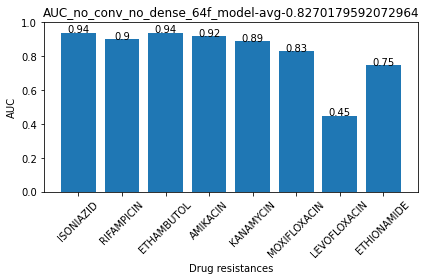

In [24]:
#%%
#device = 'cpu'

device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_split_model_128f64n-20e-spe30-rand5'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)

    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())


auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_64f_model', auc_dict)


sample model trained with random samples - longer epoch for training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1051/1051 [00:38<00:00, 27.63it/s]
/mnt/storageG1/lwang/miniconda3/envs/ml-g1/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/tmp/ipykernel_57682/3127424605.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


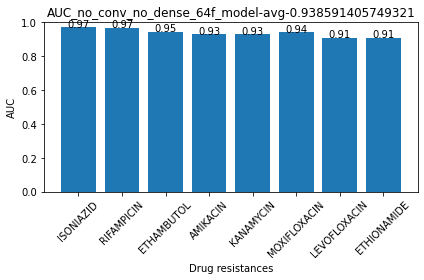

In [27]:
#%%
#device = 'cpu'

device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, y_batch in tqdm(loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)

    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    y_.append(y_batch.detach().cpu())


auc_dict = auc_func(preds, y_)
auc_plot('no_conv_no_dense_64f_model', auc_dict)


trying out the above model on consensus sequences

In [ ]:
import subprocess

with open("sample_names.txt", "r") as f:
    data = f.read()
    data_into_list = data.split("\n")

accuracy = []
outcome = []
# sample_path = '/mnt/storage7/jody/tb_ena/per_sample/'
device = "cuda" if torch.cuda.is_available() else "cpu"

for i in tqdm(data_into_list):
    #get sample names right
    sample = i
    #creating one hot seq
    #running model
    full_seq = pd.read_csv(f'./docker_ohe/{sample}/{sample}oh.csv', header=0) #! gap_oh testing using input with XXX as gap , oh -> no gap

    full_seq_input = torch.tensor(full_seq.values).T.to(device).float()
    full_seq_input = full_seq_input[None, :]
    
    m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
    ).to(device)
    m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))

    m.eval()
    preds = []

    y_pred_logits = m(full_seq_input)
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    #adding predicting to preds_all
    # preds_all.append([preds])
    acc, df_ = output_accuracy(preds, spread_sheet, sample)
    accuracy.append(acc)
    outcome.append(df_)

In [30]:
np.mean(accuracy)

0.9046969696969698

running the above model on raw reads (middle grounds)

In [31]:

start_time = time.time()
single_test_data = pd.read_csv('./test/merged-file', sep=" ", header=None)
single_test_data.columns = ['seq']
single_test_data['x'] = 'X'*25
single_test_data['x_added'] = single_test_data['x'] + single_test_data['seq'] + single_test_data['x']
single_test_data = single_test_data.drop(['x','seq'], axis = 1)
single_test_data['x_added'] = single_test_data['x_added'].str.split('',expand=True).fillna('X').apply(lambda x: x.str.cat(sep=''), axis=1)

array_ = np.array_split(single_test_data, 422)
single_test_data_mod = array_[0]

for x in range(1,len(array_)):  
    single_test_data_mod = single_test_data_mod + array_[x].reset_index(drop=True)

single_test_data_mod['_'] = 0
single_test_data = single_test_data_mod

print("--- %s seconds ---" % (time.time() - start_time))

--- 102.35195207595825 seconds ---


In [ ]:
import subprocess

with open("sample_names.txt", "r") as f:
    data = f.read()
    data_into_list = data.split("\n")

accuracy = []
outcome = []
# sample_path = '/mnt/storage7/jody/tb_ena/per_sample/'
device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
num_classes=len(DRUGS),
num_filters=128,
num_conv_layers=0,
num_dense_neurons=64,
num_dense_layers=0,
return_logits=True,
).to(device)
m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))


for x_batch, _ in tqdm(test_loader):
    x_batch = x_batch.to(device)

    m.eval()
    preds = []

    y_pred_logits = m(x_batch)
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    #adding predicting to preds_all
    # preds_all.append([preds])
    # acc, df_ = output_accuracy(preds, spread_sheet, sample)
    # accuracy.append(acc)
    # outcome.append(df_)

In [35]:
#%%
#device = 'cpu'

start_time = time.time()

test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, collate_fn=collate_padded_batch
)

device = "cuda" if torch.cuda.is_available() else "cpu"

m = Model(
    num_classes=len(DRUGS),
    num_filters=128,
    num_conv_layers=0,
    num_dense_neurons=64,
    num_dense_layers=0,
    return_logits=True,
).to(device)


m.load_state_dict(torch.load('/mnt/storageG1/lwang/TB-AMR-CNN/Julian/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))
m.eval()

# from torchsummary import summary
torchsummary.summary(m, (4, 50000))


preds = []
y_ = []

# for epoch in range(N_epochs):
#     loss_per_batch = []
# acc = AccumulatingMaskedAccuracy(drugs=DRUGS, device=device)
for x_batch, _ in tqdm(test_loader):
    x_batch = x_batch.to(device)
    # optimizer.zero_grad()
    y_pred_logits = m(x_batch)
    # loss = masked_BCE_from_logits(y_batch, y_pred_logits)
    # loss.backward()
    # optimizer.step()
    # print(f"batch loss={round(loss.item(), 4)}", end="\r")
    # loss_per_batch.append(loss.item())
    # update accuracy metric
    y_pred = torch.sigmoid(y_pred_logits)
    preds.append(y_pred.detach().cpu())
    # y_.append(y_batch.detach().cpu())
    # y_pred_array = y_pred.detach().cpu().numpy()
    # y_pred_array = y_pred_array.tolist()
    # y_batch_auc = y_batch.detach().cpu().numpy().tolist()
    # print(y_batch_auc)
    # preds.extend(y_pred_array)
    # acc.update(y_batch, y_pred)
# epoch_loss = np.array(loss_per_batch).mean()
# loss_per_epoch.append(epoch_loss)
# accs.append(acc.values)
# print(f"epoch {epoch}: loss={round(epoch_loss, 4)}")
# print(acc)
    # print(preds)
# auc_dict = auc_func(preds, y_)
# auc_plot('no_conv_no_dense_128f64n_model', auc_dict)


print("--- %s seconds ---" % (time.time() - start_time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 4, 50000]               0
            Conv1d-2           [-1, 128, 49976]          12,928
       BatchNorm1d-3           [-1, 128, 49976]             256
              ReLU-4           [-1, 128, 49976]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 13]             845
Total params: 22,413
Trainable params: 22,413
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.76
Forward/backward pass size (MB): 147.94
Params size (MB): 0.09
Estimated Total Size (MB): 148.79
-----------------------------------------

100%|██████████| 1553/1553 [00:12<00:00, 120.03it/s]

--- 12.963756322860718 seconds ---


In [37]:
preds1 = torch.cat(preds)
preds1 = torch.round(preds1)
final_pred = torch.sum(preds1, dim=0)
dr = ['AMIKACIN', 'CAPREOMYCIN', 'CIPROFLOXACIN', 'ETHAMBUTOL', 'ETHIONAMIDE',
       'ISONIAZID', 'KANAMYCIN', 'LEVOFLOXACIN', 'MOXIFLOXACIN', 'OFLOXACIN',
       'PYRAZINAMIDE', 'RIFAMPICIN', 'STREPTOMYCIN']

list_ = ["rifampicin","isoniazid","ethambutol","pyrazinamide","streptomycin","ofloxacin","moxifloxacin","levofloxacin","amikacin","kanamycin","capreomycin","ciprofloxacin","prothionamide","ethionamide","clarithromycin","clofazimine","bedaquiline","cycloserine","linezolid","para-aminosalicylic_acid","rifabutin","delamanid"]
y_true_df = pd.DataFrame(columns=list_)
y_true = ['1','1','1','1','1','0','0','NA','0','0','0','NA','NA','1','NA','NA','NA','0','0','0','NA','NA']
y_true_df .loc[0] = y_true
y_true_df = y_true_df.loc[:,["amikacin","capreomycin","ciprofloxacin","ethambutol","ethionamide","isoniazid","kanamycin","levofloxacin","moxifloxacin","ofloxacin","pyrazinamide","rifampicin","streptomycin"]]

df_ = pd.DataFrame(columns=dr)
results = final_pred.numpy().tolist()
df_.loc[0] = results
df_.loc[1] = y_true_df.loc[0].tolist()

df_

,AMIKACIN,CAPREOMYCIN,CIPROFLOXACIN,ETHAMBUTOL,ETHIONAMIDE,ISONIAZID,KANAMYCIN,LEVOFLOXACIN,MOXIFLOXACIN,OFLOXACIN,PYRAZINAMIDE,RIFAMPICIN,STREPTOMYCIN
0,445.0,347.0,440.0,329.0,312.0,661.0,444.0,883.0,11.0,274.0,255.0,857.0,310.0
1,0,0,NA,1,1,1,0,NA,0,0,1,1,1
